# GridSearchCV 활용법
- GridSearchCV 사용
- Popeline과 같이 사용하기

# 1.보스턴 집값 데이터셋 활용하여 회귀모델 만들기

## 필요 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd

from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 보스터 집값 데이터 가져오기

In [116]:
from sklearn.datasets import load_boston

In [119]:
boston = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [4]:
df = pd.DataFrame(boston['data'], columns=boston['feature_names'])

In [5]:
df['target'] = boston['target']

In [6]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [80]:
col_name = df.columns[:-1]
col_name

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

## X, y 분리

In [7]:
X = df.drop('target', axis=1).values
y = df['target'].values

## Train , Test 데이터셋 나누기

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((354, 13), (152, 13), (354,), (152,))

## 모델별 성능을 저장하기 위한 함수 선언

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

#RMSE를 구해서 시각화해줌
def rmse_eval(name_, pred, actual):
    global predictions
    global colors

    rmse = np.sqrt(mean_squared_error(actual, pred))
    my_predictions[name_] = rmse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'RMSE'])
    print(df)
    min_ = df['RMSE'].min() -1
    max_ = 5
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['RMSE'])
    
    for i, v in enumerate(df['RMSE']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('RMSE', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()


#acc를 구해서 시각화해줌
def acc_eval(name_, pred, actual):
    global predictions
    global colors

    acc = (pred==actual).mean()
    my_predictions[name_] = acc


    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    print(df)
    min_ = df['acc'].min() -1
    max_ = 1.2
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])
    
    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('Accuracy', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()

#acc를 구해서 시각화해줌(cross_val_score 사용하는 경우)
def acc_eval_add(name_, acc):
    global predictions
    global colors

    my_predictions[name_] = acc


    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    print(df)
    min_ = df['acc'].min() -1
    max_ = 1.2
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])
    
    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('Accuracy', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()
    
#실수로 잘못 넣은 경우 해당 모델을 삭제
def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

## LinearRegression 모델 

In [87]:
lg = LinearRegression()

In [88]:
lg.fit(X_train, y_train)

LinearRegression()

In [89]:
lg_y_test_pred = lg.predict(X_test)

In [90]:
# RMSE(root mean Squared error)
np.sqrt(mean_squared_error(y_test, lg_y_test_pred))

4.638689926172788

              model     RMSE
0  LinearRegression  4.63869


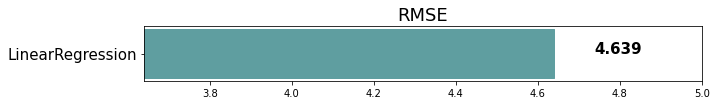

In [95]:
rmse_eval('LinearRegression', lg_y_test_pred, y_test)

## SVR 모델 및 GridSearchCV 최적 하이퍼파리미터 찾기

In [23]:
svr = SVR()

In [24]:
parms = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]
}

#### GridSearchCV scoring 사용옵션
- Classification : accuracy, precision, recall, f1, roc_auc
- Regression : neg_mean_squared_error,  neg_mean_absolute_error, neg_root_mean_squared_error, neg_mean_squared_log_error, r2


In [28]:
svr_gs_model = GridSearchCV(svr, parms, scoring='neg_mean_squared_error',  n_jobs=-1, cv=5)

In [29]:
svr_gs_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [32]:
svr_gs_model.best_score_ , svr_gs_model.best_params_

(-36.76307258834358, {'C': 100, 'gamma': 0.001})

In [33]:
svr_y_test_pred = svr_gs_model.best_estimator_.predict(X_test)

In [35]:
# RMSE(root mean Squared error)
np.sqrt(mean_squared_error(y_test, svr_y_test_pred))

4.649025085461175

              model      RMSE
0  SVR_GridSearchSV  3.224666
1  LinearRegression  4.638690


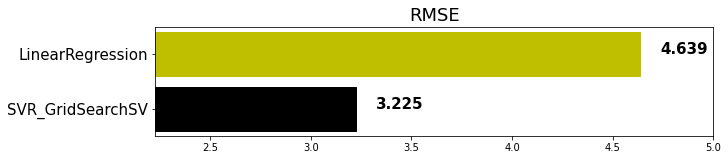

In [96]:
rmse_eval('SVR_GridSearchSV', svr_y_test_pred, y_test)

## RandomForest 모델 및 GridSearchCV 최적 하이퍼파리미터 찾기

In [36]:
rfr = RandomForestRegressor()

In [48]:
parms = {
    'n_estimators': [50, 70, 100],
    'max_features' : [0.8, 0.9]
}

In [49]:
rfr_gs_model = GridSearchCV(rfr, parms, scoring='neg_mean_squared_error',  n_jobs=-1, cv=5)

In [50]:
rfr_gs_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.8, 0.9],
                         'n_estimators': [50, 70, 100]},
             scoring='neg_mean_squared_error')

In [51]:
rfr_gs_model.best_score_ , rfr_gs_model.best_params_

(-13.592330156613144, {'max_features': 0.8, 'n_estimators': 70})

In [52]:
rfr_y_test_pred = rfr_gs_model.best_estimator_.predict(X_test)

In [53]:
# RMSE(root mean Squared error)
np.sqrt(mean_squared_error(y_test, rfr_y_test_pred))

2.968415372344513

              model      RMSE
0   RF_GridSearchSV  2.908850
1  SVR_GridSearchSV  3.224666
2  LinearRegression  4.638690


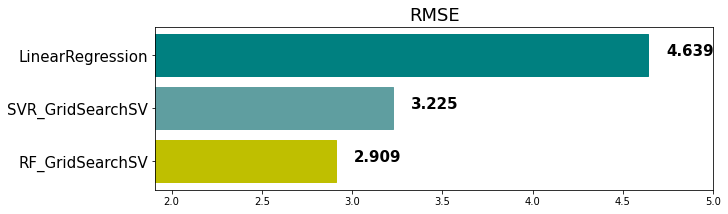

In [97]:
rmse_eval('RFR_GridSearchSV', rfr_y_test_pred, y_test)

# Pipeline과 GridSearchCV 같이 활용하기

## SVR , GridSearchCV, Pipeline 사용

In [98]:
svr_pipeline = Pipeline([
    ('MinMaxSclaer', MinMaxScaler()),
    ('SVR', SVR())
])

In [99]:
# Pipeline 정의에서 사용한 모델 이름과 모델 파라미터 같이 써야 함. 
parms = {
    'SVR__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'SVR__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]
}

In [100]:
svr_pl_gs_model = GridSearchCV(svr_pipeline, parms, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)

In [101]:
svr_pl_gs_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('MinMaxSclaer', MinMaxScaler()),
                                       ('SVR', SVR())]),
             n_jobs=-1,
             param_grid={'SVR__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'SVR__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [102]:
svr_pl_gs_model.best_score_ , svr_pl_gs_model.best_params_

(-10.43767418973274, {'SVR__C': 100, 'SVR__gamma': 1})

In [103]:
svr_pl_y_test_pred = svr_pl_gs_model.best_estimator_.predict(X_test)

In [104]:
# RMSE(root mean Squared error)
np.sqrt(mean_squared_error(y_test, svr_pl_y_test_pred))

3.2246663319836064

                 model      RMSE
0      RF_GridSearchSV  2.908850
1     SVR_GridSearchSV  3.224666
2  SVR_PL_GridSearchSV  3.224666
3     LinearRegression  4.638690


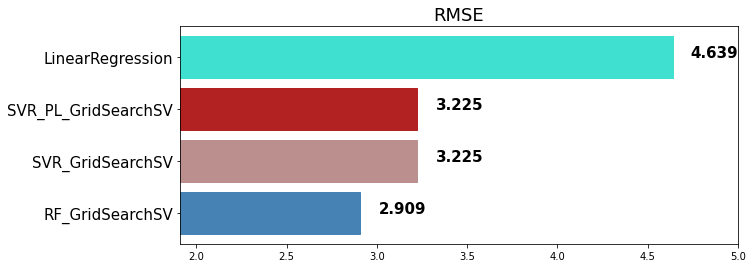

In [105]:
rmse_eval('SVR_PL_GridSearchSV', svr_pl_y_test_pred, y_test)

## RandomForest , GridSearchCV, Pipeline 사용

In [106]:
rfr_pipeline = Pipeline([
    ('MinMaxSclaer', MinMaxScaler()),
    ('RFR', RandomForestRegressor())
])

In [107]:
# Pipeline 정의에서 사용한 모델 이름과 모델 파라미터 같이 써야 함. 
parms = {
    'RFR__n_estimators': [50, 70, 100],
    'RFR__max_features' : [0.8, 0.9]
}

In [108]:
rfr_pl_gs_model = GridSearchCV(rfr_pipeline, parms, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)

In [109]:
rfr_pl_gs_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('MinMaxSclaer', MinMaxScaler()),
                                       ('RFR', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'RFR__max_features': [0.8, 0.9],
                         'RFR__n_estimators': [50, 70, 100]},
             scoring='neg_mean_squared_error')

In [110]:
rfr_pl_gs_model.best_score_ , rfr_pl_gs_model.best_params_

(-14.035338132878906, {'RFR__max_features': 0.8, 'RFR__n_estimators': 70})

In [111]:
rfr_pl_y_test_pred = rfr_pl_gs_model.best_estimator_.predict(X_test)

In [112]:
# RMSE(root mean Squared error)
np.sqrt(mean_squared_error(y_test, rfr_pl_y_test_pred))

3.0210668498703575

                 model      RMSE
0      RF_GridSearchSV  2.908850
1  RFR_PL_GridSearchSV  3.021067
2     SVR_GridSearchSV  3.224666
3  SVR_PL_GridSearchSV  3.224666
4     LinearRegression  4.638690


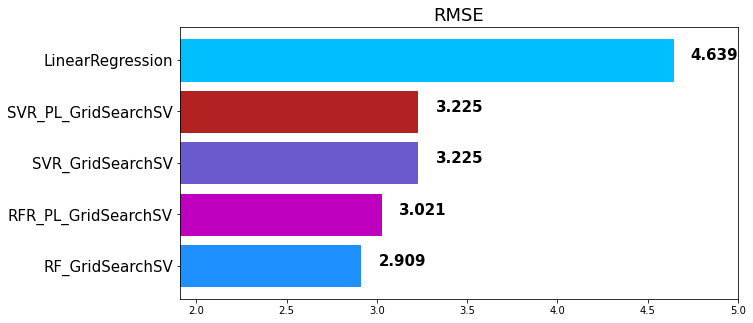

In [113]:
rmse_eval('RFR_PL_GridSearchSV', rfr_pl_y_test_pred, y_test)

## RandomForest Feature Importance 바차트 그리기

LSTAT      0.403381
RM         0.374209
DIS        0.065977
CRIM       0.043626
NOX        0.029308
PTRATIO    0.020709
AGE        0.015389
INDUS      0.014577
TAX        0.013460
B          0.012237
dtype: float64


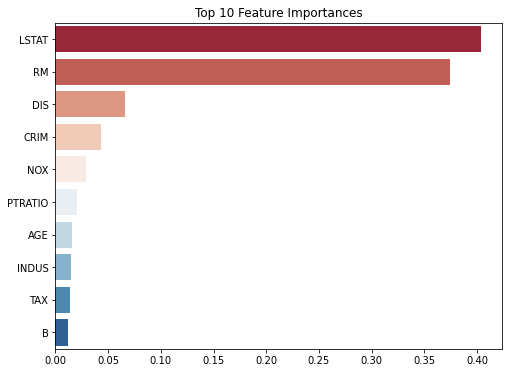

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

rfr = RandomForestRegressor(max_features=0.8, n_estimators=70)
rfr.fit(X_train, y_train)

grb_importances_values = rfr.feature_importances_
grb_importances = pd.Series(grb_importances_values, index = col_name)
grb_top10 = grb_importances.sort_values(ascending=False)[:10]

print(grb_top10)

plt.rcParams["font.family"] = 'NanumGothicCoding'
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances')
sns.barplot(x=grb_top10, y=grb_top10.index, palette = "RdBu")
plt.show()

# 2.유방암 데이터셋 활용하여 분류하기

## 필요 라이브러리 불러오기

In [129]:
import numpy as np
import pandas as pd

from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 유방암 데이터 가져오기

In [117]:
from sklearn.datasets import load_breast_cancer

In [120]:
cancer = load_breast_cancer()

In [121]:
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])

In [122]:
df['target'] = cancer['target']

In [123]:
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [124]:
col_name = df.columns[:-1]
col_name

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

## X, y 분리

In [125]:
X = df.drop('target', axis=1).values
y = df['target'].values

## Train , Test 데이터셋 나누기

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [127]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 30), (171, 30), (398,), (171,))

## 모델별 성능을 저장하기 위한 함수 선언

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

#RMSE를 구해서 시각화해줌
def rmse_eval(name_, pred, actual):
    global predictions
    global colors

    rmse = np.sqrt(mean_squared_error(actual, pred))
    my_predictions[name_] = rmse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'RMSE'])
    print(df)
    min_ = df['RMSE'].min() -1
    max_ = 5
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['RMSE'])
    
    for i, v in enumerate(df['RMSE']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('RMSE', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()


#acc를 구해서 시각화해줌
def acc_eval(name_, pred, actual):
    global predictions
    global colors

    acc = (pred==actual).mean()
    my_predictions[name_] = acc


    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    print(df)
    min_ = df['acc'].min() -1
    max_ = 1.2
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])
    
    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('Accuracy', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()

#acc를 구해서 시각화해줌(cross_val_score 사용하는 경우)
def acc_eval_add(name_, acc):
    global predictions
    global colors

    my_predictions[name_] = acc


    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    print(df)
    min_ = df['acc'].min() -1
    max_ = 1.2
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])
    
    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('Accuracy', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()
    
#실수로 잘못 넣은 경우 해당 모델을 삭제
def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

## 분류모델의 성능 표시 : 정확도, 정밀도, 재현율, F1 Score, Roc Auc

In [161]:
def classification_display(actual, pred):
  print(f'Accuracy Score : {accuracy_score(actual, pred):.4f}')
  print(f'Precision Score : {precision_score(actual, pred):.4f}')
  print(f'Recall Score : {recall_score(actual, pred):.4f}')
  print(f'F1 Score : {f1_score(actual, pred):.4f}')
  print(f'Roc Auc Score : {roc_auc_score(actual, pred):.4f}')


## LinearRegression 모델 

In [147]:
lg = LogisticRegression(max_iter=3000)

In [148]:
lg.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [149]:
lg_y_test_pred = lg.predict(X_test)

In [162]:
classification_display(y_test,lg_y_test_pred )

Accuracy Score : 0.9766
Precision Score : 0.9815
Recall Score : 0.9815
F1 Score : 0.9815
Roc Auc Score : 0.9749


                model       acc
0    SVC_GridSearchSV  0.929825
1    LinearRegression  0.976608
2  LogisticRegression  0.976608


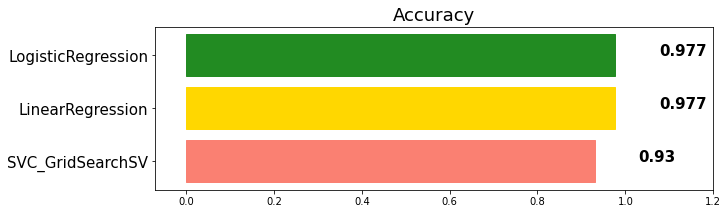

In [165]:
acc_eval('LogisticRegression', lg_y_test_pred, y_test)

## SVC 모델 및 GridSearchCV 최적 하이퍼파리미터 찾기

In [155]:
svc = SVC()

In [156]:
parms = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]
}

#### GridSearchCV scoring 사용옵션
- Classification : accuracy, precision, recall, f1, roc_auc
- Regression : neg_mean_squared_error,  neg_mean_absolute_error, neg_root_mean_squared_error, neg_mean_squared_log_error, r2


In [157]:
svc_gs_model = GridSearchCV(svc, parms, scoring='accuracy',  n_jobs=-1, cv=5)

In [158]:
svc_gs_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [159]:
svc_gs_model.best_score_ , svc_gs_model.best_params_

(0.9119303797468354, {'C': 1, 'gamma': 0.001})

In [160]:
svc_y_test_pred = svc_gs_model.best_estimator_.predict(X_test)

In [163]:
classification_display(y_test, svc_y_test_pred )

Accuracy Score : 0.9298
Precision Score : 0.9706
Recall Score : 0.9167
F1 Score : 0.9429
Roc Auc Score : 0.9345


                model       acc
0    SVC_GridSearchSV  0.929825
1    LinearRegression  0.976608
2  LogisticRegression  0.976608


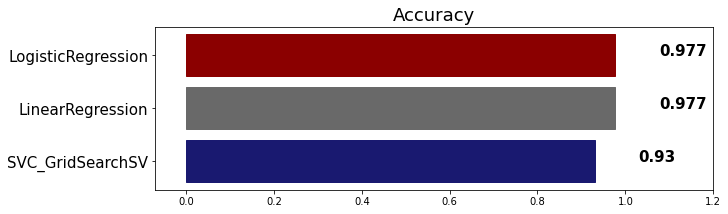

In [166]:
acc_eval('SVC_GridSearchSV', svc_y_test_pred, y_test)

## RandomForestRegressor 모델 및 GridSearchCV 최적 하이퍼파리미터 찾기

In [168]:
rfc = RandomForestClassifier()

In [169]:
parms = {
    'n_estimators': [50, 70, 100],
    'max_features' : [0.8, 0.9]
}

In [170]:
rfc_gs_model = GridSearchCV(rfc, parms, scoring='accuracy',  n_jobs=-1, cv=5)

In [171]:
rfc_gs_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.8, 0.9],
                         'n_estimators': [50, 70, 100]},
             scoring='accuracy')

In [172]:
rfc_gs_model.best_score_ , rfc_gs_model.best_params_

(0.9497784810126584, {'max_features': 0.8, 'n_estimators': 50})

In [173]:
rfc_y_test_pred = rfc_gs_model.best_estimator_.predict(X_test)

In [ ]:
classification_display(y_test, rfc_y_test_pred )

2.968415372344513

                model       acc
0    SVC_GridSearchSV  0.929825
1    RFC_GridSearchSV  0.953216
2    LinearRegression  0.976608
3  LogisticRegression  0.976608


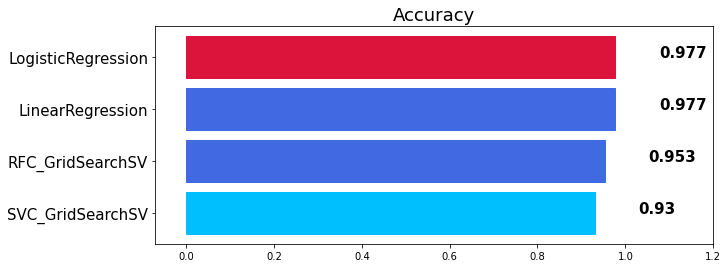

In [174]:
acc_eval('RFC_GridSearchSV', rfc_y_test_pred, y_test)

# Pipeline과 GridSearchCV 같이 활용하기

## SVC , GridSearchCV, Pipeline 사용

In [175]:
svc_pipeline = Pipeline([
    ('MinMaxSclaer', MinMaxScaler()),
    ('SVC', SVC())
])

In [176]:
# Pipeline 정의에서 사용한 모델 이름과 모델 파라미터 같이 써야 함. 
parms = {
    'SVC__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'SVC__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]
}

In [180]:
svc_pl_gs_model = GridSearchCV(svc_pipeline, parms, scoring='accuracy', n_jobs=-1, cv=5)

In [181]:
svc_pl_gs_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('MinMaxSclaer', MinMaxScaler()),
                                       ('SVC', SVC())]),
             n_jobs=-1,
             param_grid={'SVC__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'SVC__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [182]:
svc_pl_gs_model.best_score_ , svc_pl_gs_model.best_params_

(0.977373417721519, {'SVC__C': 10, 'SVC__gamma': 0.1})

In [183]:
svc_pl_y_test_pred = svc_pl_gs_model.best_estimator_.predict(X_test)

In [184]:
classification_display(y_test, svc_pl_y_test_pred )

Accuracy Score : 0.9883
Precision Score : 0.9818
Recall Score : 1.0000
F1 Score : 0.9908
Roc Auc Score : 0.9841


                 model       acc
0     SVC_GridSearchSV  0.929825
1     RFC_GridSearchSV  0.953216
2     LinearRegression  0.976608
3   LogisticRegression  0.976608
4  SVC_PL_GridSearchSV  0.988304


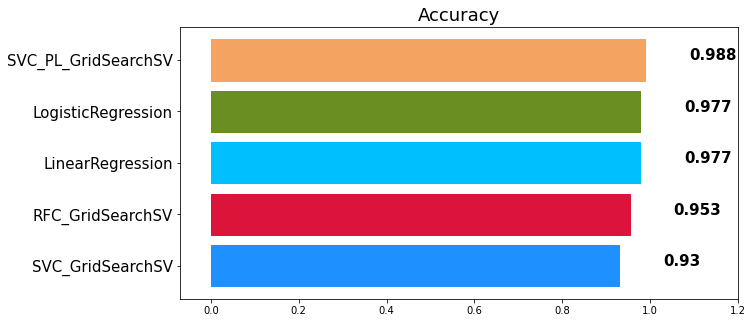

In [186]:
acc_eval('SVC_PL_GridSearchSV', svc_pl_y_test_pred, y_test)

## RandomForestClassifier , GridSearchCV, Pipeline 사용

In [187]:
rfc_pipeline = Pipeline([
    ('MinMaxSclaer', MinMaxScaler()),
    ('RFC', RandomForestClassifier())
])

In [188]:
# Pipeline 정의에서 사용한 모델 이름과 모델 파라미터 같이 써야 함. 
parms = {
    'RFC__n_estimators': [50, 70, 100],
    'RFC__max_features' : [0.8, 0.9]
}

In [189]:
rfc_pl_gs_model = GridSearchCV(rfc_pipeline, parms, scoring='accuracy', n_jobs=-1, cv=5)

In [190]:
rfc_pl_gs_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('MinMaxSclaer', MinMaxScaler()),
                                       ('RFC', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RFC__max_features': [0.8, 0.9],
                         'RFC__n_estimators': [50, 70, 100]},
             scoring='accuracy')

In [191]:
rfc_pl_gs_model.best_score_ , rfc_pl_gs_model.best_params_

(0.9497151898734175, {'RFC__max_features': 0.8, 'RFC__n_estimators': 50})

In [192]:
rfc_pl_y_test_pred = rfc_pl_gs_model.best_estimator_.predict(X_test)

In [193]:
classification_display(y_test, rfc_pl_y_test_pred )

Accuracy Score : 0.9649
Precision Score : 0.9722
Recall Score : 0.9722
F1 Score : 0.9722
Roc Auc Score : 0.9623


                 model       acc
0     SVC_GridSearchSV  0.929825
1     RFC_GridSearchSV  0.953216
2  RFC_PL_GridSearchSV  0.964912
3     LinearRegression  0.976608
4   LogisticRegression  0.976608
5  SVC_PL_GridSearchSV  0.988304


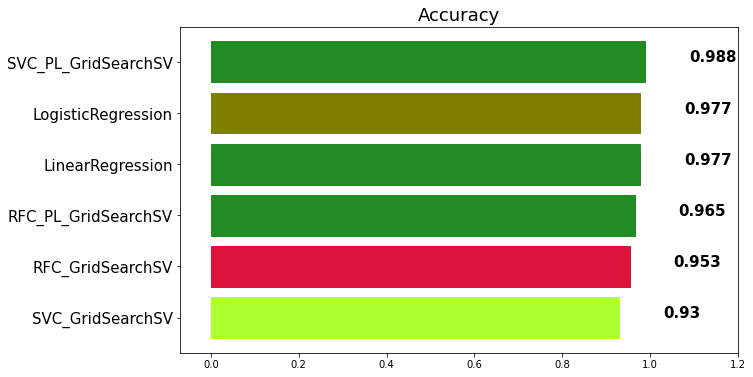

In [195]:
acc_eval('RFC_PL_GridSearchSV', rfc_pl_y_test_pred, y_test)

## RandomForest Feature Importance 바차트 그리기

mean concave points        0.309552
worst concave points       0.239010
worst perimeter            0.122960
worst radius               0.101339
worst area                 0.054445
worst texture              0.028977
mean texture               0.021743
area error                 0.019628
worst concavity            0.013240
fractal dimension error    0.008529
dtype: float64


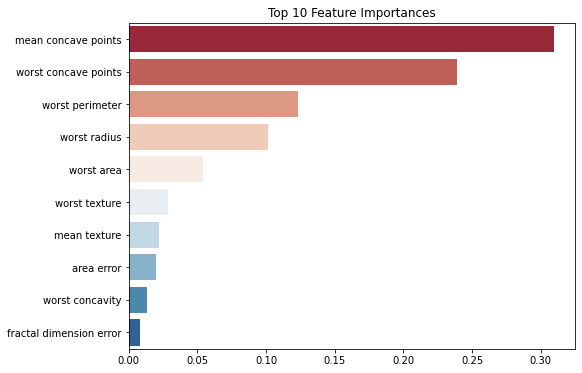

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

rfr = RandomForestClassifier(max_features=0.8, n_estimators=50)
rfr.fit(X_train, y_train)

grb_importances_values = rfr.feature_importances_
grb_importances = pd.Series(grb_importances_values, index = col_name)
grb_top10 = grb_importances.sort_values(ascending=False)[:10]

print(grb_top10)

plt.rcParams["font.family"] = 'NanumGothicCoding'
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances')
sns.barplot(x=grb_top10, y=grb_top10.index, palette = "RdBu")
plt.show()